# Estimating Click through rate IPS vs Likelihood (Beta Bayes) vs Bayes
In this notebook we do a simple recommenation (conextual bandit) problem where we have a catalogue of 5 items, two phones, two grains and beer.  We have a bandit signal that is good on some actions for some contexts and poor in other actions and contexts.

We compare: 
* Beta Bayes A Bayesian approach based on a uniform prior
* IPS esimator approach
* A complex Bayesian model that has access to embeddings knowing the phones are similar, the grains are similar and the beer is distinct.  It uses a BLOB like model using the three distances of recommendation action-history, action-action, history-history.  The model is developed with Stan.  For more information on the model see https://arxiv.org/pdf/2008.12504.pdf and https://www.youtube.com/watch?v=DrsFfor1n3U 


IPS based estimation can suffer from:
* Increased variance by violating conditionality.  Expected impressions are used instead of impressions.
* The estimate can be greater than one, the error bar can be greater than one or negative
* Poor estimation of uncertainty as a root mean squaed estimator is used (rather than using the number of impressions)
* No simple way to borrow strength - is much easier when product embeddings are availabile for BLOB like models


In [1]:
from matplotlib import *
from numpy import *
from scipy.stats import distributions as d
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import pystan
P=5
K=3

# stan indexes from 1
CityPhone =   1
DronePhone =  2
couscous = 3
rice = 4
beer = 5

name_map = {CityPhone: 'City Phone', DronePhone: 'Drone Phone', couscous: 'Couscous', rice: 'Rice', beer: 'Beer'}

# An embedding provided that gives similarities between products
Psi = array([[1,0,0],[1.1,0.2,0],[0,2,0],[0,1.5,0.1],[0,.75,1.3]])


# toy data set

# user history
H = array([CityPhone, CityPhone,  CityPhone,   CityPhone, CityPhone, DronePhone, DronePhone, rice,   rice,    rice,     rice,   rice, beer, beer, beer])
A = array([CityPhone, DronePhone, couscous, rice,   beer,   DronePhone, CityPhone,  CityPhone, DronePhone, couscous, rice,   beer, rice, beer, CityPhone])
I = array([1000,   11,      50,       2,      5,      623,     1000,    10,     30,      4,        100,    50,   20,   52,   23])
C = array([  10,   0,       0,       0,      1,        8,       20,     0,      0,      0,          0,     0,    1,    1,    0])
N = len(H)

df = pd.DataFrame({'H': [name_map[H[c-1]] for c in range(1,1+len(H))],'A': [name_map[A[c-1]] for c in range(1,1+len(A))],'I':I, 'C':C})
df

,H,A,I,C
0,City Phone,City Phone,1000,10
1,City Phone,Drone Phone,11,0
2,City Phone,Couscous,50,0
3,City Phone,Rice,2,0
4,City Phone,Beer,5,1
5,Drone Phone,Drone Phone,623,8
6,Drone Phone,City Phone,1000,20
7,Rice,City Phone,10,0
8,Rice,Drone Phone,30,0
9,Rice,Couscous,4,0


In [2]:
def do_plot(table, target=plt):
    yerr = vstack([table['theta50']-table['theta10'],table['theta90']-table['theta50']])
    q=target.errorbar('H=' + table['H'] + '  A=' + table['A'], table['theta50'],yerr=yerr,fmt='.')
    q=target.xticks(rotation=90)
    return q

def plot_table(table,ylim=[0, 1], target=plt):
    for h in set(table['H']):
        do_plot(table[table['H']==h], plt)
        
    axes = plt.gca()
    axes.set_ylim(ylim)


In [3]:
phi0_S = dict((df.groupby(['H']).sum())['I'])
df['phi0_S'] = [phi0_S[h] for h in df['H']]
df['P(A|H)'] = df['I'] / df['phi0_S'] # be kind to the frequentists..  Assuming E[Impressions]=Impressions
df['CTR_IPS'] = df['C'] / (df['phi0_S'] * df['P(A|H)'])

In [4]:
std_l_ips = []
ctr_min_beta = []
ctr_max_beta = []
ctr = []
for ii in range(len(df)):
    i = df.I[ii]
    c = df.C[ii]
    p_a_h = df['P(A|H)'][ii]
    std_error_ips = std(hstack((ones(c)/p_a_h,zeros(i-c)))) / sqrt(i)
    std_l_ips.append(std_error_ips)
    ctr.append(c/i)
    ctr_min_beta.append(scipy.stats.distributions.beta.ppf(0.9,c+1,i-c+1))
    ctr_max_beta.append(scipy.stats.distributions.beta.ppf(0.1,c+1,i-c+1))
ctr = array(ctr)
df['ctr_min_ips'] = ctr - 1.28 * array(std_l_ips)
df['ctr_max_ips'] = ctr + 1.28 * array(std_l_ips)
df['ctr_min_beta'] = array(ctr_min_beta)
df['ctr_max_beta'] = array(ctr_max_beta)
df['ctr'] = ctr

In [5]:
QQ, RR = meshgrid(array(range(P)), array(range(P)))

table = pd.DataFrame({'H': [name_map[ii] for ii in QQ.reshape(P**2) + 1],
 'A': [name_map[ii] for ii in RR.reshape(P**2) + 1]})

table = pd.merge(table,how='left',right=df)

table['theta10'] = table['ctr_min_ips']
table['theta90'] = table['ctr_max_ips']
table['theta50'] = table['ctr']

table_ips = table

Text(0.5, 1.0, 'IPS estimate')

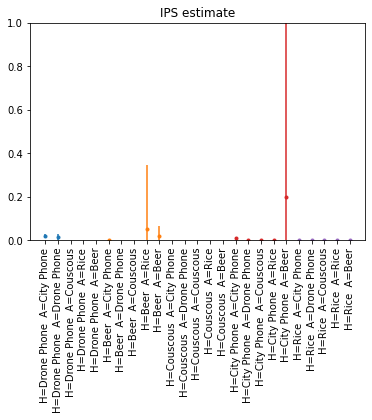

In [6]:
plot_table(table)
plt.title('IPS estimate')

Text(0.5, 1.0, 'IPS estimate')

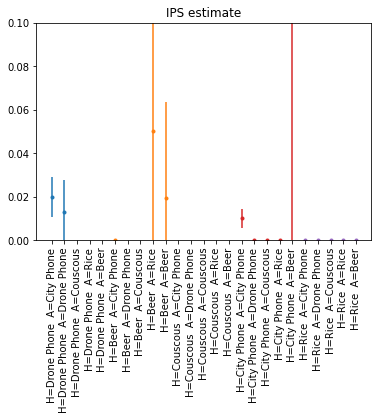

In [7]:
plot_table(table,[0, 0.1])
plt.title('IPS estimate')

Bayesian Conjugate analysis 

In [8]:
QQ, RR = meshgrid(array(range(P)), array(range(P)))

table = pd.DataFrame({'H': [name_map[ii] for ii in QQ.reshape(P**2) + 1],
 'A': [name_map[ii] for ii in RR.reshape(P**2) + 1]})

table = pd.merge(table,how='left',right=df)
table.loc[isnan(table['I']),'I'] = 0
table.loc[isnan(table['C']),'C'] = 0

table['theta10'] = scipy.stats.distributions.beta.ppf(0.1, table.C+1, table.I-table.C+1)
table['theta50'] = scipy.stats.distributions.beta.ppf(0.5, table.C+1, table.I-table.C+1)
table['theta90'] = scipy.stats.distributions.beta.ppf(0.9, table.C+1, table.I-table.C+1)


table = table[['H', 'A', 'theta10', 'theta50', 'theta90']]
table_beta = table

Text(0.5, 1.0, 'Beta Bayes')

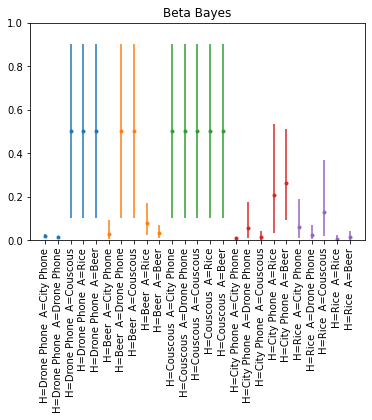

In [9]:
plot_table(table)
plt.title('Beta Bayes')

Text(0.5, 1.0, 'Beta Bayes')

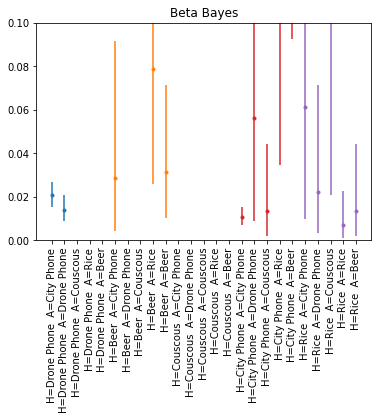

In [11]:
plot_table(table,[0,0.1])
plt.title('Beta Bayes')


We now present a sophisticated Bayesian analysis that leverages all 3 distances...

In [12]:
script = """
data {
  int P;
  int K;
  int N;
  int H[N];
  int A[N];
  int I[N];
  int C[N];
    
  matrix[P,K] Psi;  
} transformed data {
  matrix[P,P] Omega;
  Omega = Psi*Psi';  // having a cosine dist here would maybe be better
}

parameters {
  matrix[P,P] logit_theta;
  real theta_mu;
  real<lower=0> lambda;
  
  vector[K] phi;
  vector[K] zeta;
}

model {
   theta_mu ~ normal(-5,1); // overall effects
   lambda ~ normal(0,4); // action matches segment effects
   phi ~ normal(0,.2); // action effects
   zeta ~ normal(0,.2); // history effects
   
   
    for (a in 1:P) {
        for (h in 1:P) {
            logit_theta[a,h] ~ normal(theta_mu + lambda * Omega[a,h]/sqrt(Omega[a,a])/sqrt(Omega[h,h]) + (Psi * phi)[a] + (Psi * zeta)[h] ,.8);
        }
    }
    
    for (n in 1:N) {
        C[n] ~ binomial_logit(I[n], logit_theta[A[n],H[n]]);
    }


} generated quantities {
    matrix[P,P] theta;
    theta = inv_logit(logit_theta);
}
"""


fit=pystan.stan(model_code=script,data={'P':P,'K':K,'N':N,'H':H,'A':A,'I':I,'C':C, 'Psi': Psi})

s = fit.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_da5aa821e9ce8e52d321eb22f7297793 NOW.


In [13]:
QQ, RR = meshgrid(array(range(P)), array(range(P)))

table = pd.DataFrame({'H': [name_map[ii] for ii in QQ.reshape(P**2) + 1],
 'A': [name_map[ii] for ii in RR.reshape(P**2) + 1],
 'theta10': percentile(s['theta'],10,0).reshape(P**2),
 'theta50': percentile(s['theta'],50,0).reshape(P**2),
 'theta90': percentile(s['theta'],90,0).reshape(P**2)})

table_3_dist = table

Text(0.5, 1.0, 'Bayes 3 Distances')

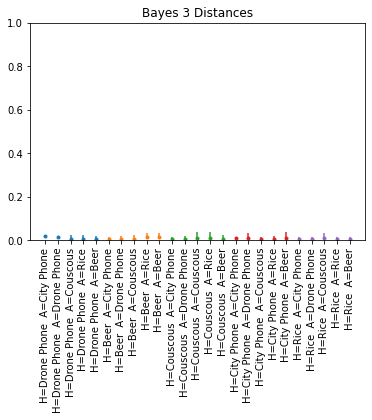

In [14]:
plot_table(table)
plt.title('Bayes 3 Distances')

Text(0.5, 1.0, 'Bayes 3 Distances')

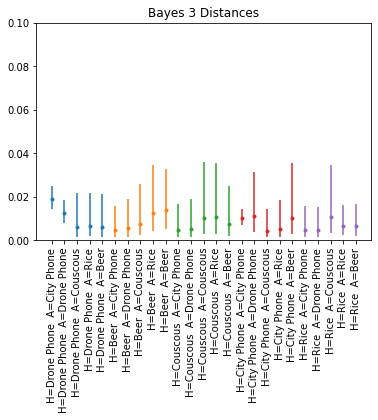

In [15]:
plot_table(table,[0,0.1])
plt.title('Bayes 3 Distances')

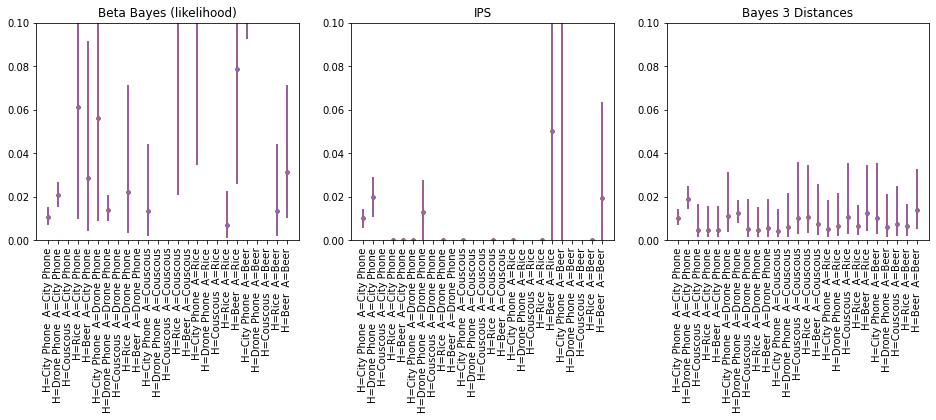

In [16]:
_, axes = plt.subplots(1,3,figsize=(16,4))


table = table_beta
yerr = vstack([table['theta50']-table['theta10'],table['theta90']-table['theta50']])
for h in set(table['H']):
    axes[0].errorbar('H=' + table['H'] + '  A=' + table['A'], table['theta50'],yerr=yerr,fmt='.')
_ = plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=90)

table = table_ips
yerr = vstack([table['theta50']-table['theta10'],table['theta90']-table['theta50']])
for h in set(table['H']):
    axes[1].errorbar('H=' + table['H'] + '  A=' + table['A'], table['theta50'],yerr=yerr,fmt='.')
_ = plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=90)

table = table_3_dist
yerr = vstack([table['theta50']-table['theta10'],table['theta90']-table['theta50']])
for h in set(table['H']):
    axes[2].errorbar('H=' + table['H'] + '  A=' + table['A'], table['theta50'],yerr=yerr,fmt='.')
_ = plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=90)

plt.ylim([0,0.1])

axes[0].set_ylim([0, 0.1])
axes[1].set_ylim([0, 0.1])
axes[2].set_ylim([0, 0.1])
axes[0].title.set_text('Beta Bayes (likelihood)')
axes[1].title.set_text('IPS')
axes[2].title.set_text('Bayes 3 Distances')
